In this notebook, we compare RK4 HOPS and RK4 HOMPS using as example the spin boson model at high temperatures and low damping, trying to find the numerical instability

In [1]:
%load_ext autoreload
%autoreload 2

In [526]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
from scipy.linalg import svd
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.homps import homps_model
from src.util import operators
from src.hops import hops
from src.util import noise_generator
from src.mps import mps
import helper_functions
import mpmath

In [15]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

In [16]:
N_terms = 1
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
g_noise, w_noise = debye_spectral_density.get_debye_coefficients(1000, T, gamma, eta)

In [224]:
N_steps = 1000
N_trunc = 30
linear = False
use_noise = True

In [225]:
def swap_from_HOPS_to_HOMPS(psi):
    """
    Helper functions that transforms a state vector
    in H_aux \kron H_phys to Hphys \kron H_aux or the other way around!
    """
    result = np.reshape(psi, (2, N_trunc))
    return np.reshape(result.T, (2*N_trunc))

In [510]:
def mp_matrix_to_numpy_array(A):
    return np.array([[np.complex256(x) for x in row] for row in A.tolist()], dtype=np.complex256)

In [511]:
def svd_exact(A, prec=100): 
    """
    Helper function that computes a SVD with 128bit precision
    """
    mp.prec = prec
    A_mp = mp.matrix(A.tolist())
    U, S, V = mp.svd(A_mp)
    U = mp_matrix_to_numpy_array(U)
    S = mp_matrix_to_numpy_array(S)[:, 0]
    V = mp_matrix_to_numpy_array(V)
    return U, S, V

In [512]:
# Prepare matrices for HOPS RK4
temp_options = {
    'linear' : linear,
    'use_noise' : use_noise,
    'method' : 'Trotter'
}
temp_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, temp_options)
Heff_linear = temp_hops.Heff_linear
if use_noise:
    Heff_noise = temp_hops.Heff_noise
if not linear:
    Heff_nonlinear = temp_hops.Heff_nonlinear

In [513]:
# Prepare MPOS for HOMPS RK4
temp_homps_model = homps_model.HOMPSModel(g, w, h, L, N_trunc)
Heff_MPO_0 = temp_homps_model.H_mpo[0].copy()
Heff_MPO_1 = temp_homps_model.H_mpo[1].copy()

In [514]:
# Prepare the noise
#zts = np.zeros(N_steps*2)
#if use_noise:
#    alpha = lambda tau : bath_correlation_function.alpha(tau, g, w) 
#    alpha0 = alpha(0)
#    generator = noise_generator.ColoredNoiseGenerator_FourierFiltering(2*N_steps, alpha, 0, duration)
#    zts = generator.sample_process()

In [515]:
def construct_RHS_HOPS(psi, memory, zt):
    Heff = Heff_linear.copy()
    if not linear:
        expL = ((np.conj(psi[0:2])@np.conj(L).T@psi[0:2])/(np.conj(psi[0:2])@psi[0:2])).item()
        Heff += expL * Heff_nonlinear
    if use_noise:
        Heff += (np.conj(zt) + memory) * Heff_noise
    memory_update = 0.
    if not linear:
        memory_update = -np.conj(w.item())*memory + np.conj(alpha0).item()*expL
    return -1.j*Heff@psi, memory_update

In [516]:
def construct_RHS_HOMPS(psi, memory, zt):
    # First test: Just contract the MPO!
    Heff_MPO = [Heff_MPO_0.copy(), Heff_MPO_1.copy()]
    if not linear:
        expL = ((np.conj(psi[0:2])@np.conj(L).T@psi[0:2])/(np.conj(psi[0:2])@psi[0:2])).item()
        Heff_MPO[0][0, 2, :, :] += 1.j * expL * eye
    if use_noise:
        Heff_MPO[0][0, 3, :, :] += 1.j * (np.conj(zt) + memory) * L
    # contract
    Heff = np.tensordot(Heff_MPO[0][0, :, :, :], Heff_MPO[1][:, -1, :, :], ([0], [0])) # [wR] i i*; [wL] j j* 
    Heff = np.transpose(Heff, (2, 0, 3, 1)) # i i* j j* -> j i j* i*
    Heff = np.reshape(Heff, (Heff.shape[0]*Heff.shape[1], Heff.shape[2]*Heff.shape[3])) # (j i), (j* i*)
    memory_update = 0.
    if not linear:
        memory_update = -np.conj(w.item())*memory + np.conj(alpha0).item()*expL
    return -1.j*Heff@psi, memory_update

In [517]:
def compute_update_HOPS(psi, memory, t_index, dt):
    k1, q1 = construct_RHS_HOPS(psi, memory, zts[2*t_index])
    k2, q2 = construct_RHS_HOPS(psi + dt/2*k1, memory + dt/2*q1, zts[2*t_index+1])
    k3, q3 = construct_RHS_HOPS(psi + dt/2*k2, memory + dt/2*q2, zts[2*t_index+1])
    k4, q4 = construct_RHS_HOPS(psi + dt*k3, memory + dt*q3, zts[2*t_index+2])
    psi_prime = psi + dt/6*(k1+2*k2+2*k3+k4)
    memory_prime = memory + dt/6*(q1+2*q2+2*q3+q4)
    return psi_prime, memory_prime

In [518]:
def compute_update_HOMPS(psi, memory, t_index, dt):
    k1, q1 = construct_RHS_HOMPS(psi, memory, zts[2*t_index])
    k2, q2 = construct_RHS_HOMPS(psi + dt/2*k1, memory + dt/2*q1, zts[2*t_index+1])
    k3, q3 = construct_RHS_HOMPS(psi + dt/2*k2, memory + dt/2*q2, zts[2*t_index+1])
    k4, q4 = construct_RHS_HOMPS(psi + dt*k3, memory + dt*q3, zts[2*t_index+2])
    psi_prime = psi + dt/6*(k1+2*k2+2*k3+k4)
    memory_prime = memory + dt/6*(q1+2*q2+2*q3+q4)
    return psi_prime, memory_prime

In [523]:
# perform time evolution

psis_HOPS = np.empty((N_steps, 2), dtype=complex)
psi_HOPS = np.zeros(N_trunc*2)
psi_HOPS[0] = 1.
psis_HOPS[0, :] = psi_HOPS[0:2]
memory_HOPS = 0.

psis_HOMPS = np.empty((N_steps, 2), dtype=np.complex256)
psi_HOMPS = np.zeros(N_trunc*2)
psi_HOMPS[0] = 1.
psis_HOMPS[0, :] = psi_HOPS[0:2]
memory_HOMPS = 0.

dt = duration/N_steps

for i in tqdm(range(N_steps-1)):
    psi_HOPS, memory_HOPS = compute_update_HOPS(psi_HOPS, memory_HOPS, i, dt)
    psi_HOPS /= np.linalg.norm(psi_HOPS)
    psis_HOPS[i+1, :] = psi_HOPS[0:2]
    
    psi_HOMPS, memory_HOMPS = compute_update_HOMPS(psi_HOMPS, memory_HOMPS, i, dt)
    psi_HOMPS /= np.linalg.norm(psi_HOMPS)
    
    #psi_HOMPS = swap_from_HOPS_to_HOMPS(psi_HOMPS)
    temp = np.reshape(psi_HOMPS, (N_trunc, 2))
    #U, S, V = svd(temp, full_matrices=False, lapack_driver='gesdd')
    #U, S, V = svd_exact(temp)
    #psi_HOMPS = np.reshape(U@np.diag(S)@V, 2*N_trunc)
    #error = np.linalg.norm(np.abs(temp - U@np.diag(S)@V)) / np.linalg.norm(np.abs(temp))
    #print(error)
    #psi_HOMPS = mps.MPS.initialize_from_state_vector(psi_HOPS.copy(), 2, chi_max=100, eps=0, d=[N_trunc, 2])
    #psi_HOMPS = helper_functions.uncompress(psi_HOMPS)
    #psi_HOMPS = swap_from_HOPS_to_HOMPS(psi_HOMPS)
    
    psis_HOMPS[i+1, :] = psi_HOMPS[0:2]

  0%|          | 0/999 [00:00<?, ?it/s]

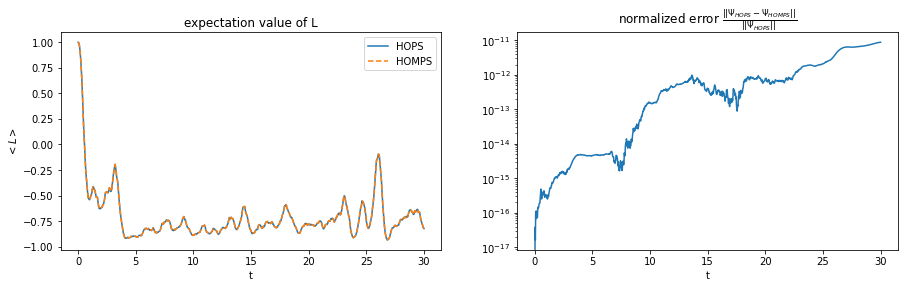

In [522]:
# compute and plot expectation values
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))

sigma_zs_HOPS = compute_exp_val_nonlinear(np.expand_dims(psis_HOPS, axis=0), sigma_z)
sigma_zs_HOMPS = compute_exp_val_nonlinear(np.expand_dims(psis_HOMPS, axis=0), sigma_z)
error = np.linalg.norm(np.abs(psis_HOPS - psis_HOMPS), axis=1) / np.linalg.norm(np.abs(psis_HOPS), axis=1)

ts = np.linspace(0, duration, N_steps)

axarray[0].plot(ts, sigma_zs_HOPS, label="HOPS")
axarray[0].plot(ts, sigma_zs_HOMPS, "--", label="HOMPS")
axarray[0].set_title("")
axarray[0].set_xlabel("t")
axarray[0].set_ylabel("$<L>$")
axarray[0].set_title("expectation value of L")
axarray[0].legend()

axarray[1].plot(ts, error)
axarray[1].set_yscale("log")
axarray[1].set_xlabel("t")
axarray[1].set_title(r"normalized error $\frac{||\Psi_{HOPS}-\Psi_{HOMPS}||}{||\Psi_{HOPS}||}$")

#plt.savefig("plots/using_contracted_MPO.pdf")
plt.show()

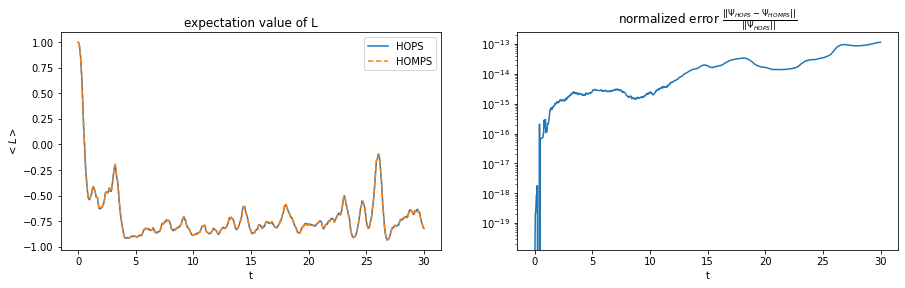

In [524]:
# compute and plot expectation values
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))

sigma_zs_HOPS = compute_exp_val_nonlinear(np.expand_dims(psis_HOPS, axis=0), sigma_z)
sigma_zs_HOMPS = compute_exp_val_nonlinear(np.expand_dims(psis_HOMPS, axis=0), sigma_z)
error = np.linalg.norm(np.abs(psis_HOPS - psis_HOMPS), axis=1) / np.linalg.norm(np.abs(psis_HOPS), axis=1)

ts = np.linspace(0, duration, N_steps)

axarray[0].plot(ts, sigma_zs_HOPS, label="HOPS")
axarray[0].plot(ts, sigma_zs_HOMPS, "--", label="HOMPS")
axarray[0].set_title("")
axarray[0].set_xlabel("t")
axarray[0].set_ylabel("$<L>$")
axarray[0].set_title("expectation value of L")
axarray[0].legend()

axarray[1].plot(ts, error)
axarray[1].set_yscale("log")
axarray[1].set_xlabel("t")
axarray[1].set_title(r"normalized error $\frac{||\Psi_{HOPS}-\Psi_{HOMPS}||}{||\Psi_{HOPS}||}$")

#plt.savefig("plots/using_contracted_MPO.pdf")
plt.show()

In [491]:
mp.prec = 100
print(mp)

Mpmath settings:
  mp.prec = 100               [default: 53]
  mp.dps = 29                 [default: 15]
  mp.trap_complex = False     [default: False]


In [492]:
N, M = 40, 50

In [493]:
def mp_matrix_to_numpy_array(A):
    return np.array([[np.complex256(x) for x in row] for row in A.tolist()], dtype=np.complex256)

In [494]:
A = np.array(np.random.random((N, M)), dtype=np.complex128) + 1.j * np.array(np.random.random((N, M)), dtype=np.complex128)
U, S, V = svd(A, full_matrices=False)
error = np.linalg.norm(np.abs(A - U@np.diag(S)@V)) / np.linalg.norm(np.abs(A))
print(error)

1.5154562546756266e-15


In [495]:
A_mp = mp.matrix(A.tolist())
U, S, V = mp.svd(A_mp)
A_compare = mp_matrix_to_numpy_array(U*mp.diag(S)*V)
#U = mp_matrix_to_numpy_array(U)
#S = mp_matrix_to_numpy_array(S)[:, 0]
#V = mp_matrix_to_numpy_array(V)

In [496]:
U_np = mp_matrix_to_numpy_array(U)
S_np = mp_matrix_to_numpy_array(S)[:, 0]
V_np = mp_matrix_to_numpy_array(V)

In [497]:
print(U[0, 0]-np.complex256(complex(U[0, 0])))

(-4.0405663577260161108025171601e-18 - 5.2767971726708879713872478729e-18j)


In [498]:
print(mp.nstr(U[0, 0], n=100))

(-0.1089235571021881134206250914033039296665050827583510561794521119549639109891359112225472927093505859 - 0.1033601815169991386432938941353882682481811766834123927783352196729804717278966563753783702850341797j)


In [499]:
error = np.linalg.norm(np.abs(A - U_np@np.diag(S_np)@V_np)) / np.linalg.norm(np.abs(A))
print(error)
error = np.linalg.norm(np.abs(A - A_compare)) / np.linalg.norm(np.abs(A))
print(error)

7.272874418072857168e-17
0.0


In [470]:
print(np.complex256(1)+np.complex256(1e-20))

(1+0j)
